In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def scatter_2class(X, y, ylabels =['y=0','y=1'], alpha = 0.8, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap ='bwr',s = 8, alpha = alpha, edgecolors = 'none')
    ax.legend(scatter.legend_elements()[0],ylabels , loc="lower right", title="Classes")
def plot_classification_region(X_test, model,  alpha = 0.5, ylabels =['y=0','y=1'] ):
    xx1, xx2 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
    XX = np.c_[xx1.ravel(), xx2.ravel()]
    YY = model.predict(XX)
    y_predict = model.predict(X_test)
    fig, ax = plt.subplots()
    scatter_2class(XX, YY, ax = ax, alpha = alpha, ylabels = ylabels)
    scatter_2class(X_test, y_predict, ax = ax,ylabels = ylabels)


# Generate Data 

We use a two-class toy dataset generated with the "make_moons" function from the scikit-learn library.
## Preprocessing
- Nomarlize data
We normalize the data using $\frac{X-\mu}{\sigma}$. 
For this, we use `StandardScaler` to ensure scaling the data. 

- Additionally, we randomly separate the dataset into training and testing sets using the `train_test_split` function.

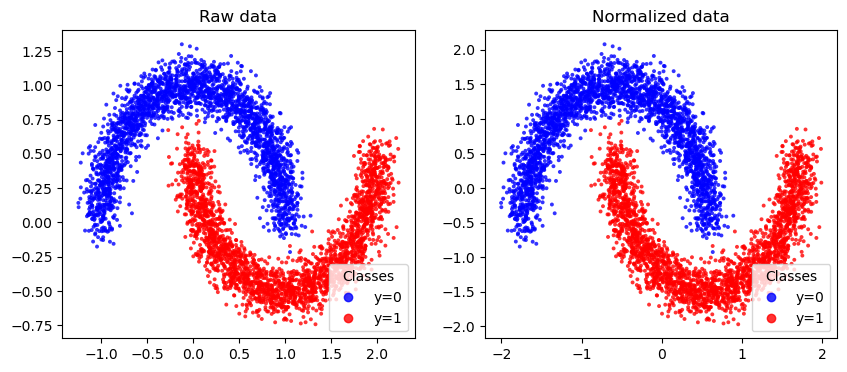

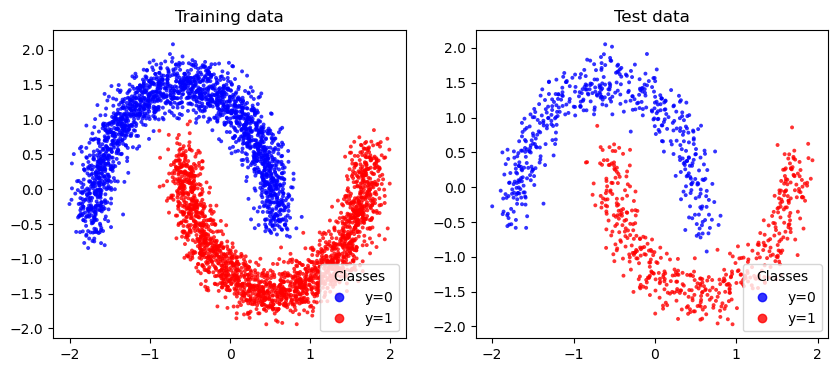

In [3]:
X,y = make_moons(noise=0.1, random_state=0,n_samples = 5000)

from sklearn.preprocessing import StandardScaler
X_norm = StandardScaler().fit_transform(X)

fig, axs = plt.subplots(1, 2, figsize = (10,4))
scatter_2class(X,y, ax = axs[0])
axs[0].set_title('Raw data')
scatter_2class(X_norm, y, ax = axs[1])
axs[1].set_title('Normalized data')
plt.show()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=0)

fig, axs = plt.subplots(1, 2, figsize = (10,4))
scatter_2class(X_train,y_train, ax = axs[0])
axs[0].set_title('Training data')
scatter_2class(X_test, y_test, ax = axs[1])
axs[1].set_title('Test data')
plt.show()

# Support Vector machine 

<!-- ## boudary 
Loss function for SVM  (Page 328)
$$L = \frac{1}{2}||w||^2 -\sum_{n=1}^N a_n \{ t_n(w^T \phi(x_n) +b)-1\} (7.7) $$  -->


##  SVM Duality
The goal of SVM is find the maximum margin solution: 
$$ \argmax_{w,b}\{\frac{1}{||w||} \min [t_n(w^T\phi(x_n) +b)]\}  (7.3)$$
whoes dual representation is : 
$$ \argmax_{a} \tilde L(a)= \sum_{n=1}^N a_n -\frac{1}{2}\sum_{n=1}^N \sum_{m=1}^N a_n a_m t_n t_m k(x_n, x_m)   (7.10, 7.32)$$
with constrants: 
$$a_n\geq 0\\
\sum_{n=1}^N a_n t_n = 0$$

The dual decision function becomes: 
$$y(x) = \sum_{n=1}^N a_n t_n k(x, x_n) +b (7.13) $$


## Please use Gradient Aescent to solve $a$ 
The first derivative of $L(a)$ over $a$: 
$$\frac{\partial L(a)}{\partial a_k}   = 1-\sum_{j = 1}^N a_j t_jt_k k(x_j, x_k) $$
Using Gradient Aescent (because we need to find the maximum of $L(a)$) :

$$a_k = a_k +\eta \frac{\partial L(a)}{\partial a_k} $$

## Finding $b$ using support vectors
$$b = \frac{1}{N_s}\sum_{n\in S} (t_n -\sum_{m\in S} a_m t_m k(x_n, x_m)))$$
where $S$ is support vectors, satisfing $t_n y(x_n) =1$. 
Using dual varaible represenation: 
$$0\leq a_n \leq C (7.33) $$
where $C$ is is a trade-off parameter between misclassficaiton penalty and the soft margin (7.21).  

In [4]:
class SVM_Dual:
# https://adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-training-algorithms/
    def __init__(self, kernel='poly', degree=2, sigma=0.1, epoches=1000, learning_rate= 0.001, C = 1):
        self.b = 0
        self.degree = degree
        self.C = C
        self.sigma = sigma
        self.epoches = epoches
        self.learning_rate = learning_rate

        if kernel == 'poly':
            self.kernel = self.polynomial_kernal # for polynomial kernal
        elif kernel == 'gaussian':
            self.kernel =  self.gaussian_kernal # for guassian kernal

    def polynomial_kernal(self,X,Z):
        return (1 + X.dot(Z.T))**self.degree  
        
    def gaussian_kernal(self, X,Z):
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X[:, np.newaxis] - Z[np.newaxis, :], axis=2) ** 2)  
    
    def fit(self,X,y):
        self.X = X
        self.y = y
        C = self.C
        a = np.random.random(X.shape[0])
        
        n_samples,n_features = X.shape

        y_mul_kernal = np.outer(y, y) * self.kernel(X, X) 
        losses =[]
        for i in range(self.epoches):
            gradient = np.ones(n_samples)  -   np.dot(y_mul_kernal,a)

            # Gradient of L(a)

            # Gradient asent to update a
            a += self.learning_rate * gradient  
         
            # loss function 
            loss = np.sum(a) - 0.5 * np.sum(np.outer(a, a) * y_mul_kernal) 
            losses.append(loss)
        # find index of support vectors  
        sv_index = np.where((a) > 0 & (a < C))[0]
        

        # decide b using support vectors
     

        b_list = y[sv_index] - (a * y).dot(self.kernel(X, X[sv_index]))
        self.b = np.mean(b_list)  
        self.a = a
        self.losses = losses
    
    
    def decision_function(self, X):
        return (self.a * self.y).dot(self.kernel(self.X, X)) + self.b
    
    def predict(self, X):
        return np.sign(self.decision_function(X))
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)


In [5]:
y_train[y_train == 0] = -1
svm = SVM_Dual(kernel ='gaussian',epoches = 500)
svm.fit(X_train,y_train)


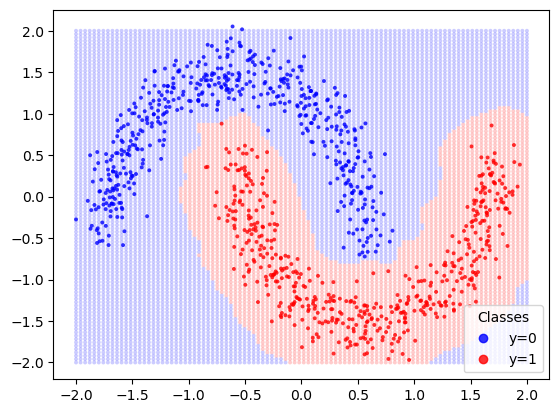

In [6]:
plot_classification_region(X_test, svm, ylabels =['y=0','y=1'],alpha = 0.2)


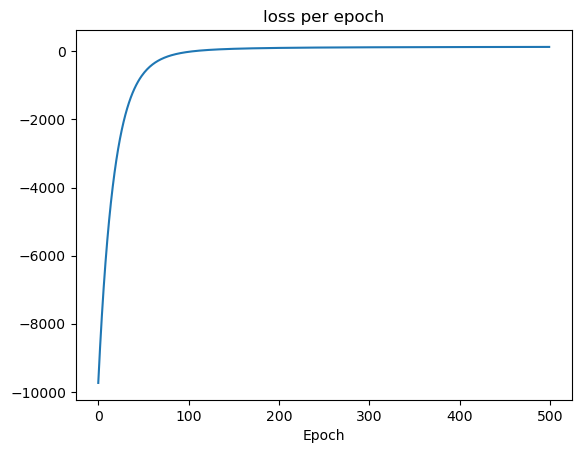

In [7]:
plt.plot(svm.losses)
plt.title("loss per epoch")
plt.xlabel('Epoch')
plt.show()

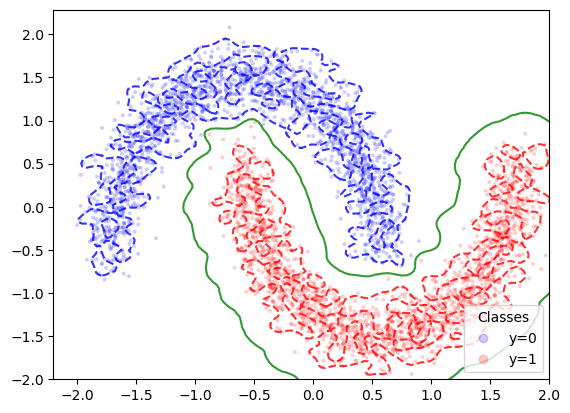

In [8]:
def plot_decision_boundary(svm):
    # plot boudary and margins
    X_train = svm.X
    y_train = svm.y
    fig,ax = plt.subplots()
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap ='bwr',s = 8, alpha = 0.2, edgecolors = 'none')
    ax.legend(scatter.legend_elements()[0],['y=0','y=1'] , loc="lower right", title="Classes")
    xx1, xx2 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
    XX = np.c_[xx1.ravel(), xx2.ravel()]
    YY = svm.decision_function(XX).reshape(xx1.shape)
    ax.contour(xx1,xx2, YY,levels=[-1, 0, 1], linestyles=['--', '-', '--'],colors =['b','g','r'], alpha = 0.8 )
    plt.show()

plot_decision_boundary(svm)